In [3]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

#%matplotlib qt

pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Load time-lapse data...

In [66]:
#folder = '/Users/jug/Repositories/GIT/BobSeg/AmyMaddox/'
#filename = folder + 'Reslice_of_298_crop.tif'

folder = '/Users/maddox/Jug/Data/'
filename = folder + 'Reslice_of_nd324_crop_16b.tif'

stack = imread(filename)
print 'Stack shape:',stack.shape

sigma = [0.,3.,3.]
stack_smooth = gaussian(stack,sigma)

Stack shape: (100, 399, 372)


### Optional line-wise normalization

In [68]:
stack_normalized = np.zeros_like(stack,dtype=float)
for t in range(len(stack)):
    for l in range(len(stack[t])):
        maximum = float( np.max(stack[t][l]) )
        stack_normalized[t][l] = stack[t][l] / maximum
sigma = [0.,3.,3.]
stack_smooth = gaussian(stack_normalized,sigma)

### Do plot to see if all is sane

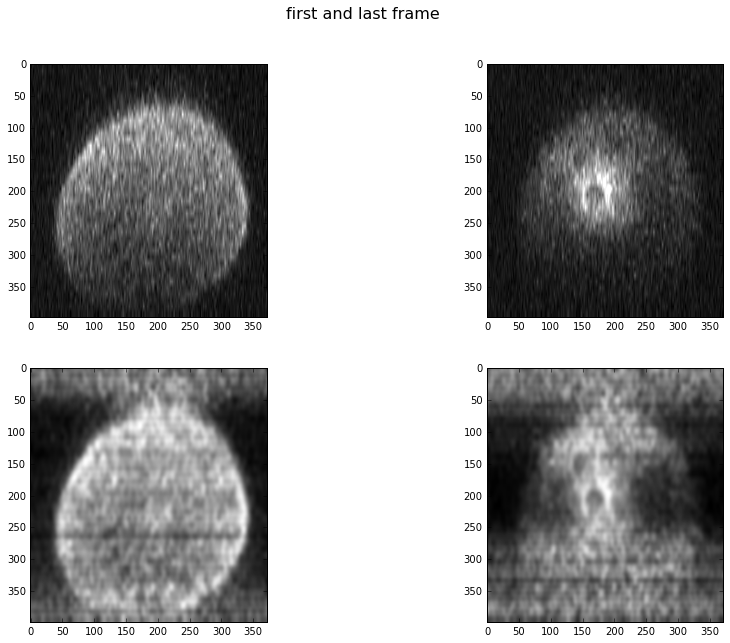

In [69]:
pylab.rcParams['figure.figsize'] = (15, 10)

fig = plt.figure()
fig.suptitle('first and last frame', fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(stack[0], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(stack[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(stack_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(stack_smooth[-1], plt.get_cmap('gray'))

In [76]:
max_rs = (stack[0].shape[1] / 2,
          stack[0].shape[1] / 2)

min_rs = (5,5)
print min_rs, max_rs

(5, 5) (186, 186)


# Adding ring

In [77]:
data = Data3d( stack_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=150,max_delta_k=3)
objects = []

In [78]:
ring = data.init_object("ring")
objects.append(ring)

In [79]:
cx = stack.shape[2] / 2
cy = stack.shape[1] / 2
data.add_object_at( ring, min_rs, max_rs, frame=0, seed=(cx,cy), segment_it=True )
data.track(ring, seed_frame=0, target_frames=range(0,len(data.images)), recenter_iterations=2)

Added appearance for "ring" in frame 0 with seed coordinates [ 186.  199.]
      Optimum energy:  37.7795195384
      Nodes in/out:  8103 2697
      Area:  61718.0
Added appearance for "ring" in frame 0 with seed coordinates [ 186.  199.]
      Optimum energy:  37.7795195384
      Nodes in/out:  8103 2697
      Area:  61718.0
    Updated center to [189 214]
    Updated center to [189 214]
Added appearance for "ring" in frame 1 with seed coordinates [ 189.  214.]
      Optimum energy:  42.6459471478
      Nodes in/out:  8290 2510
      Area:  63357.0
    Updated center to [190 221]
    Updated center to [190 221]
Added appearance for "ring" in frame 2 with seed coordinates [ 190.  221.]
      Optimum energy:  40.2570554831
      Nodes in/out:  8238 2562
      Area:  62339.0
    Updated center to [191 225]
    Updated center to [191 225]
Added appearance for "ring" in frame 3 with seed coordinates [ 191.  225.]
      Optimum energy:  44.0727561371
      Nodes in/out:  8309 2491
      Are

In [80]:
data.segment2dt( ring, max_radial_delta=3 )

Results for frame 0:
      Optimum energy:  2245.36796343
      Area:  62680.5
Results for frame 1:
      Optimum energy:  2245.36796343
      Area:  63115.0
Results for frame 2:
      Optimum energy:  2245.36796343
      Area:  63472.0
Results for frame 3:
      Optimum energy:  2245.36796343
      Area:  64044.5
Results for frame 4:
      Optimum energy:  2245.36796343
      Area:  64315.0
Results for frame 5:
      Optimum energy:  2245.36796343
      Area:  64581.5
Results for frame 6:
      Optimum energy:  2245.36796343
      Area:  65227.5
Results for frame 7:
      Optimum energy:  2245.36796343
      Area:  65922.0
Results for frame 8:
      Optimum energy:  2245.36796343
      Area:  65840.5
Results for frame 9:
      Optimum energy:  2245.36796343
      Area:  66489.5
Results for frame 10:
      Optimum energy:  2245.36796343
      Area:  67053.5
Results for frame 11:
      Optimum energy:  2245.36796343
      Area:  66285.0
Results for frame 12:
      Optimum energy:  2245.

# Check results

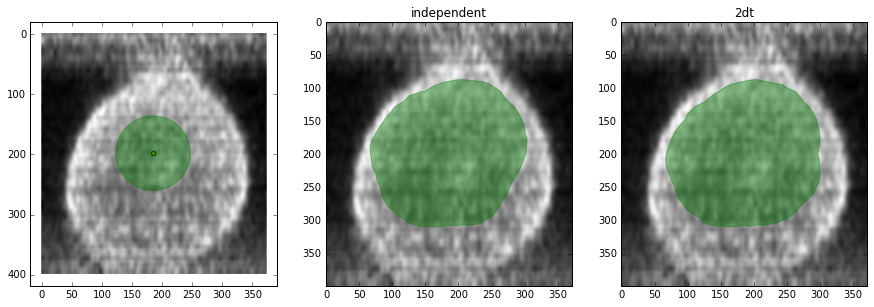

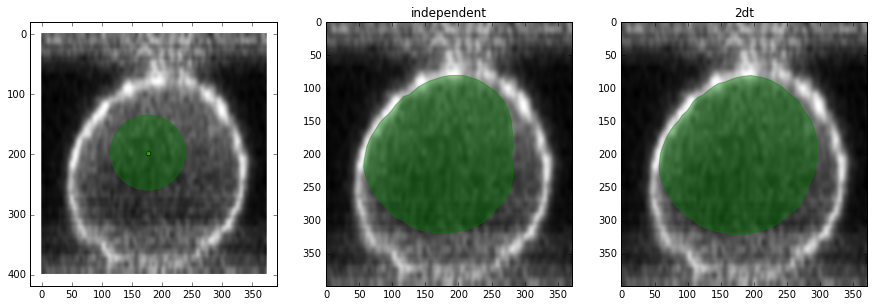

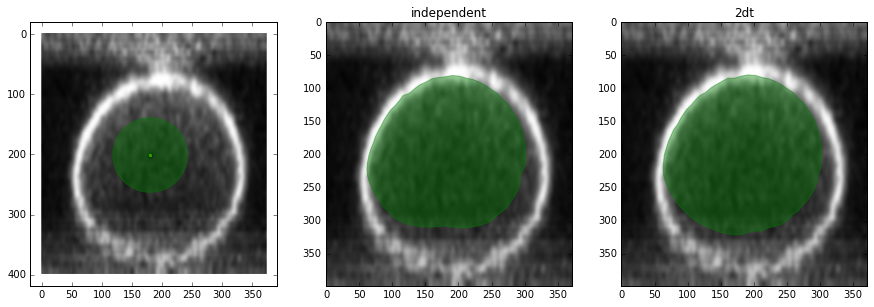

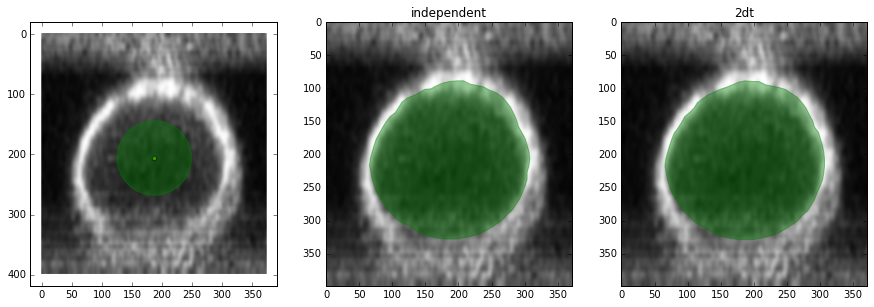

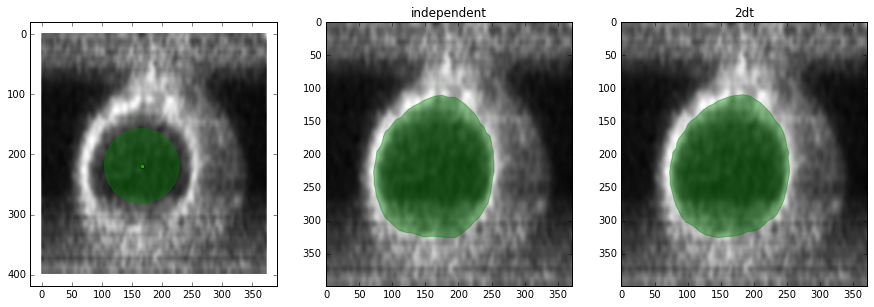

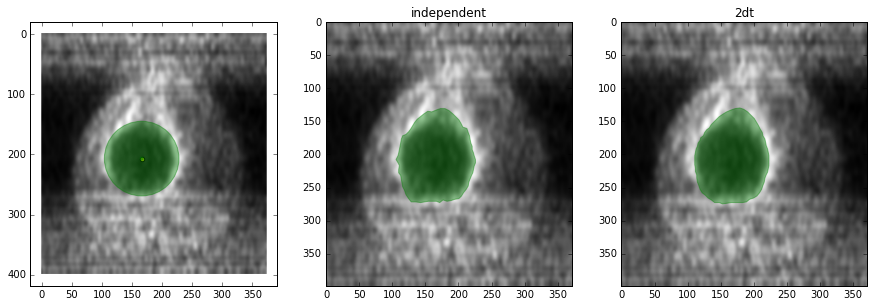

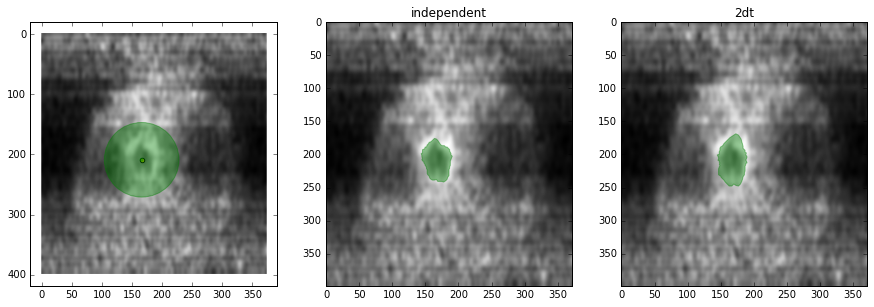

In [75]:
pylab.rcParams['figure.figsize'] = (15, 7)
for frame in range(1,len(data.images),len(data.images)/6):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax )

# Create and show segmentation movie
_Note:_ this also creates the data you might want to export below... so you cannot skip this step if you are interested in doing so!

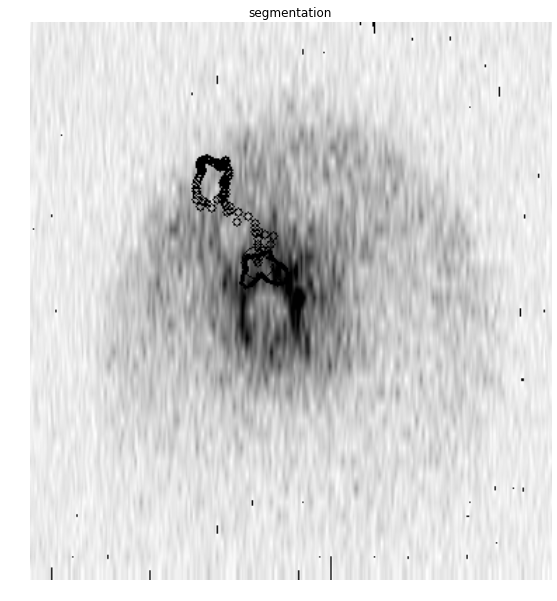

In [24]:
(frames, centers, polygones, radii) = data.draw_segmentation(stack, folder=None, inline=True)

### Store movie frames in a folder

In [21]:
for f in range(len(frames)):
    imsave(folder+'movie_export/frame%02d.tif'%(f), frames[f])

# Store data for later processing
_Note:_ I assume here that you only segmented one single object in your movie (which is not crazy to assume since you will only have one ring in your images, right?). Anyways, if you segmented multiple objects only the first one will be exported...

In [27]:
data_filename = folder+'data.jug'
str_now = datetime.datetime.now().strftime("%B %d, %Y at %I:%M%p")

with open(data_filename, "w") as data_file:
    data_file.write("# Exported after processing '%s' on %s\n\n" % (filename,str_now))
    for t in range(len(frames)):
        data_file.write("t, %d\n"%t)
        data_file.write("c, %d, %d\n"%(centers[t][0],centers[t][1]))
        data_file.write("r, %d\n"%radii[t])
        polygone = polygones[t][0] # we will only export the first polygone here!
        for p in range(len(polygone)):
            #absolute point coordinates: 
            #  data_file.write("p%d, %d, %d\n"%(p,polygone[p][0],polygone[p][1]))
            data_file.write("p%d, %d, %d\n"%(p,polygone[p][0]-centers[t][0],polygone[p][1]-centers[t][1]))
        data_file.write("\n")

In [16]:
np.shape(polygones)

(100, 1, 72, 2)

In [20]:
t=50
object_id=0
vector_id=20
polygones[t][object_id][vector_id]

(134, 108)